# Classificazione automatica delle emozioni nei tweet con NLP e RoBERTa

## Introduzione

In questo notebook affrontiamo il compito di classificazione automatica delle emozioni nei tweet, sfruttando tecniche avanzate di Natural Language Processing (NLP) e modelli di Machine Learning.

L’obiettivo è risolvere un problema di classificazione multiclasse: a partire da un dataset di tweet, il modello dovrà associare a ciascun testo una tra le quattro possibili classi emozionali:
- *anger* (0)
- *joy* (1)
- *optimism* (2)
- *sadness* (3)

Per raggiungere questo scopo, abbiamo strutturato il workflow in step chiari e riproducibili:

- Analisi esplorativa e pulizia del dataset;
- Preprocessing del testo (gestione di emoji, emoticons, hashtag, menzioni, ecc.);
- Data augmentation per migliorare la varietà e la generalizzazione del modello e per bilanciare il dataset sbilanciato;
- Addestramento di un classificatore basato su RoBERTa;
- Valutazione delle performance tramite metriche standard (accuracy, F1-score, confusion matrix);
- Generazione delle predizioni finali sui dati di test.

L’obiettivo finale è costruire una pipeline completa, ottimizzata e facilmente replicabile, documentando ogni fase del processo per garantire trasparenza e massima comprensione delle scelte effettuate.


In [1]:
# Import di base
import numpy as np
import pandas as pd
import re
import random

# Visualizzazione e analisi
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Dataset e NLP
from datasets import Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score

# Preprocessing testo
import wordsegment as ws
import emot

# NLP avanzato
import nltk
from nltk.corpus import wordnet

# ML e deep learning
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

# Utility PyTorch
from torchinfo import summary

# Impostazioni pandas
pd.set_option('display.max_colwidth', None)

# Download risorse e inizializzazioni
nltk.download('wordnet')
ws.load()
emot_obj = emot.core.emot()


c:\Users\conti\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import del dataset

Il dataset fornito è composto dai seguenti file:

- `train_text.txt`: contiene i tweet per l'addestramento;
- `train_labels.txt`: contiene le labels dei tweet per l'addestramento;
- `val_text.txt`: contiene i tweet per la validazione;
- `val_labels.txt`: contiene le labels dei tweet per la validazione;
- `test_text.txt`: contiene i tweet di test da cui ricavare le predizioni;
- `mapping.txt`: contiene i tipi di labels del dataset

Per la creazione dei dataframe, creiamo due colonne: `text` (contenente i tweet) e, solo per quanto concerne train e validation, `label` (contenente le etichette).

In [2]:
train_text_path = "emotion/train_text.txt"
train_labels_path = "emotion/train_labels.txt"
val_text_path = "emotion/val_text.txt"
val_labels_path = "emotion/val_labels.txt"
test_text_path = "emotion/test_text.txt"
mapping_path = "emotion/mapping.txt"

# Carichiamo i tweet dai file di testo
with open(train_text_path, "r", encoding="utf-8") as f:
    train_lines = [line.strip() for line in f] 
with open(val_text_path, "r", encoding="utf-8") as f:
    val_lines = [line.strip() for line in f] 
with open(test_text_path, "r", encoding="utf-8") as f:
    test_lines = [line.strip() for line in f] 

df_train = pd.DataFrame(train_lines, columns=["text"])
df_val = pd.DataFrame(val_lines, columns=["text"])
df_test = pd.DataFrame(test_lines, columns=["text"])

# SOLO PER TRAIN E VALIDATION, aggiungiamo la colonna label
df_train['label'] = pd.read_csv(train_labels_path, header=None, dtype=int)
df_val['label'] = pd.read_csv(val_labels_path, header=None, dtype=int)

# Stampiamo il dataset di train
df_train

,text,label
0,“Worry is a down payment on a problem you may never have'. Joyce Meyer. #motivation #leadership #worry,2
1,My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs,0
2,No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu,1
3,"Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight",0
4,it's pretty depressing when u hit pan on ur favourite highlighter,3
...,...,...
3252,"I get discouraged because I try for 5 fucking years a contact with Lady Gaga but are thousands of tweets, how she would see my tweet? :(",3
3253,The @user are in contention and hosting @user nation and Camden is empty #sad,3
3254,"@user @user @user @user @user as a fellow UP grad, i shiver at the shallowness of his arguments",0
3255,You have a #problem? Yes! Can you do #something about it? No! Than why,0


Il nostro dataset si presenta attualmente nella forma più grezza possibile:

- Testo con emoticons, emoji, hashtags e menzioni;
- Etichetta numerica associata.

Carichiamo anche il file di mapping per vedere la mappatura delle classi.

In [3]:
# Creiamo un dizionario per mappare i numeri delle classi con le etichette
labels = {}

# Carichiamo il file di mapping
with open(mapping_path, "r", encoding="utf-8") as f:
    for line in f:
        key, value = line.strip().split()
        labels[int(key)] = value

print(f"Numero di classi: {len(labels)}")
print(labels)

Numero di classi: 4
{0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}


# Analisi dei dati

### Valori NaN

In [4]:
# Verifichiamo l'eventuale presenza di valori NaN
print("Nan train set:")
print(df_train.isna().sum())
print("\nNan validation set:")
print(df_val.isna().sum())
print("\nNan test set:")
print(df_test.isna().sum())

Nan train set:
text     0
label    0
dtype: int64

Nan validation set:
text     0
label    0
dtype: int64

Nan test set:
text    0
dtype: int64


In questo caso siamo fortunati in quanto non ve ne sono, quindi possiamo procedere col resto dell'analisi senza eliminare nulla.

### Distribuzione delle classi

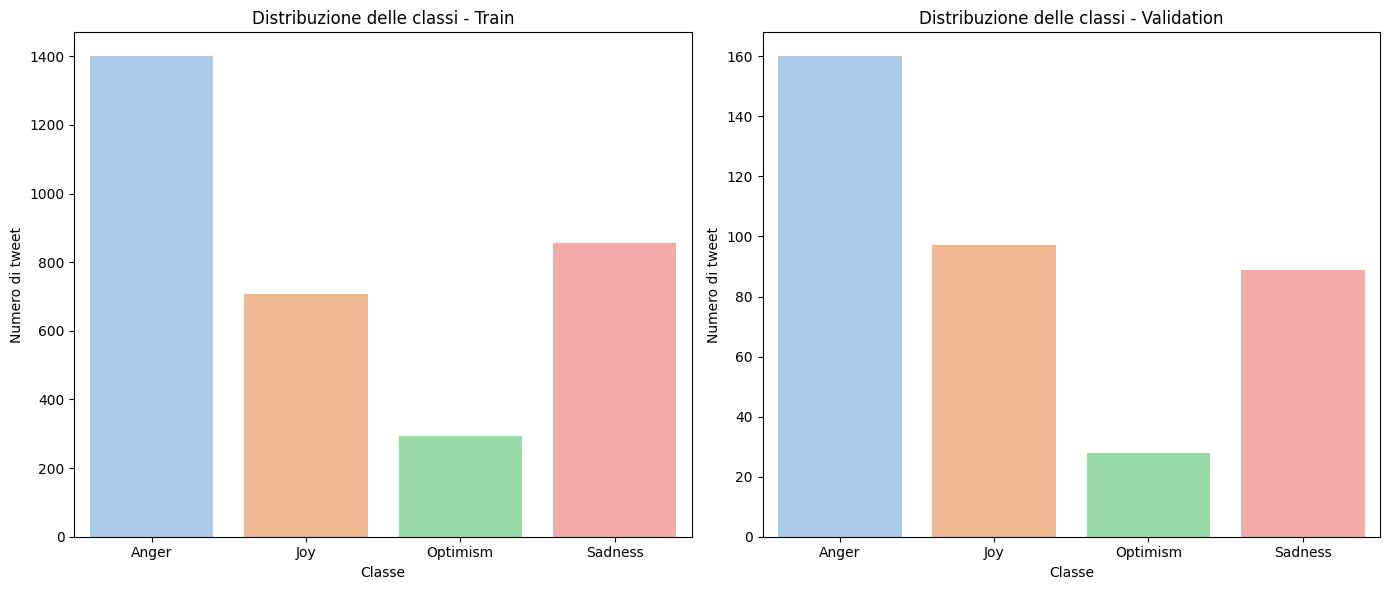

Distribuzione delle classi nel dataset di train:
label
0    0.429843
3    0.262512
1    0.217378
2    0.090267
Name: proportion, dtype: float64

Distribuzione delle classi nel dataset di validation:
label
0    0.427807
1    0.259358
3    0.237968
2    0.074866
Name: proportion, dtype: float64


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribuzione delle classi nel dataset di train
sns.countplot(ax=axes[0], x=df_train['label'], hue=df_train['label'], legend=False, palette="pastel")
axes[0].set_title("Distribuzione delle classi - Train")
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("Numero di tweet")
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels(["Anger", "Joy", "Optimism", "Sadness"])

# Distribuzione delle classi nel dataset di validation
sns.countplot(ax=axes[1], x=df_val['label'], hue=df_val['label'], legend=False, palette="pastel")
axes[1].set_title("Distribuzione delle classi - Validation")
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Numero di tweet")
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(["Anger", "Joy", "Optimism", "Sadness"])

plt.tight_layout()
plt.show()

print("Distribuzione delle classi nel dataset di train:")
print(df_train["label"].value_counts(normalize=True))
print("")
print("Distribuzione delle classi nel dataset di validation:")
print(df_val["label"].value_counts(normalize=True))

### Parole frequenti

In [6]:
def plot_frequent_words(texts, title, max_features=20):
    """Funzione per visualizzare le parole più frequenti in un dataset di testi.
    Args:
        texts (list of str): Lista di testi (tweet).
        title (str): Titolo del grafico.
        max_features (int): Numero massimo di parole da visualizzare.
    """

    # Creiamo il vettorizzatore (bag-of-words)
    vectorizer = CountVectorizer(max_features=max_features, stop_words="english")
    word_counts = vectorizer.fit_transform(texts)  # Applica il conteggio delle parole

    # Sommiamo le frequenze globali
    word_sums = word_counts.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    # Ordiniamo per frequenza
    sorted_idx = np.argsort(word_sums)[::-1]  # indici in ordine decrescente
    word_sums = word_sums[sorted_idx]
    words = words[sorted_idx]

    # Creiamo un grafico per visualizzare le parole più frequenti
    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_sums, y=words)
    plt.title(title)
    plt.xlabel("Frequenza")
    plt.ylabel("Parole")
    plt.show()

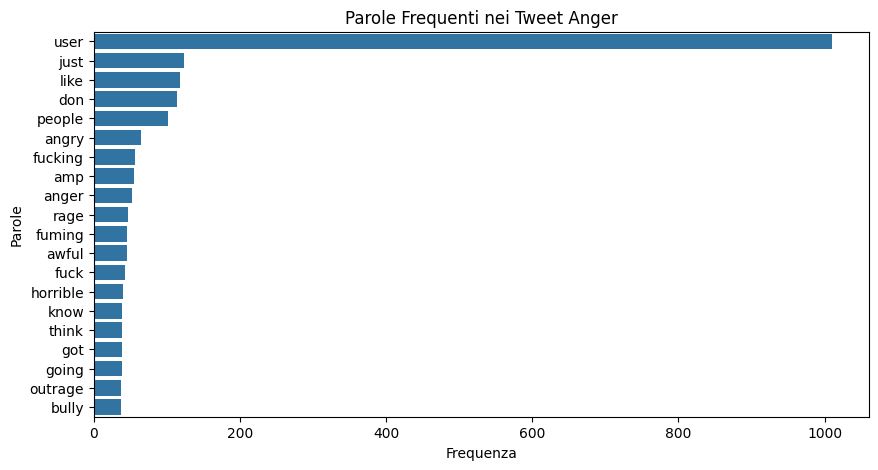

In [7]:
# Plottiamo le parole frequenti nei tweet anger
plot_frequent_words(df_train[df_train['label'] == 0]['text'], "Parole Frequenti nei Tweet Anger")

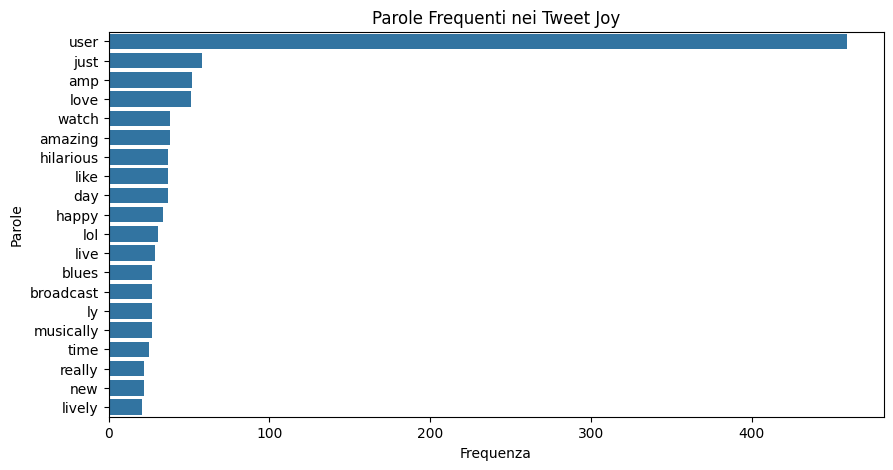

In [8]:
# Plottiamo le parole frequenti nei tweet Joy
plot_frequent_words(df_train[df_train['label'] == 1]['text'], "Parole Frequenti nei Tweet Joy")

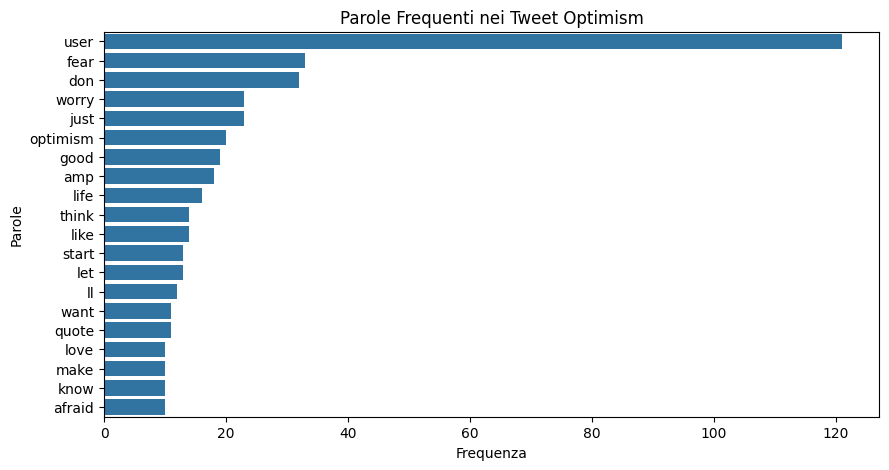

In [9]:
# Plottiamo le parole frequenti nei tweet Optimism
plot_frequent_words(df_train[df_train['label'] == 2]['text'], "Parole Frequenti nei Tweet Optimism")

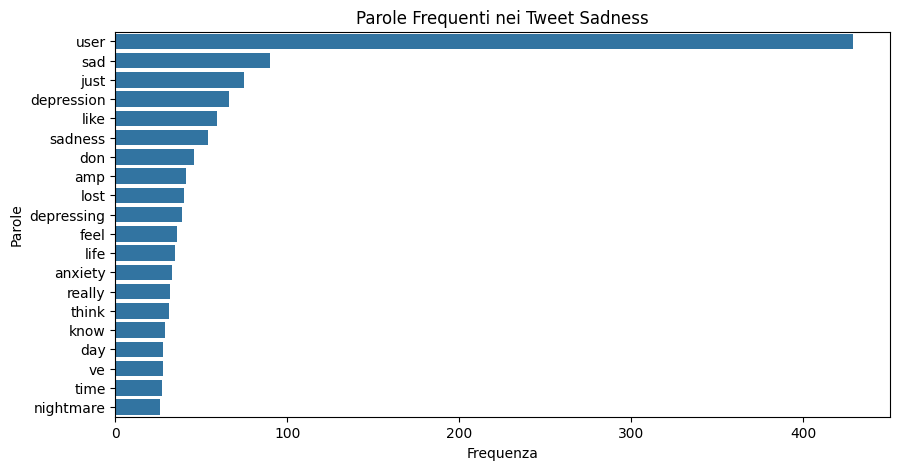

In [10]:
# Plottiamo le parole frequenti nei tweet Sadness
plot_frequent_words(df_train[df_train['label'] == 3]['text'], "Parole Frequenti nei Tweet Sadness")

Possiamo notare una prevalenza della parola `user`, la quale tuttavia sarà rimossa in fase di pre-processing in quanto corrispondente ad una menzione. Aldilà di queste, vi è qualche parola che possa favorire una classe rispetto ad un'altra in un determinato tweet.

# Preprocessing dei dati

In [11]:
def sanitize_text(txt: str) -> str:
    """Pulisce il testo rimuovendo caratteri speciali e spazi multipli."""
    # Sostituiamo i caratteri di nuova linea, tabulazione e ritorno a capo con uno spazio
    txt = txt.replace("\\n", " ").replace("\\t", " ").replace("\\r", " ")
    txt = re.sub(r"[\n\t\r]+", " ", txt)
    # Rimuoviamo spazi multipli e strip finale
    return re.sub(r"\s+", " ", txt).strip()

def convert_emoticons_to_text(text):
    """Converte le emoticons in testo."""
    emoticons = emot_obj.emoticons(text)['value']
    for emoticon in emoticons:
        # Sostituiamo le emoticons con il loro significato
        meaning = emot_obj.emoticons(emoticon)['mean'][0]
        text = text.replace(emoticon, f" {meaning} ")

    return text

def convert_emojis_to_text(text):
    """Converte le emoji in testo."""
    emojis = emot_obj.emoji(text)['value']
    # Se ci sono emoji
    if emojis:
        for emoji in emojis:
            if emot_obj.emoji(emoji)['mean']:
                # Ricaviamo il significato dell'emoji
                emoji_meaning = emot_obj.emoji(emoji)['mean'][0]
                # Rimuoviamo i due punti e sostituisci l'underscore con uno spazio
                emoji_meaning = emoji_meaning.replace(':', '').replace('_', ' ')
                # Sostituiamo l'emoji con il suo significato nel testo
                text = text.replace(emoji, f" {emoji_meaning} ")

    return text

def split_hashtags(text):
    """Suddivide gli hashtag in parole."""
    # Inserisce uno spazio davanti a ogni hashtag non preceduto da spazio
    text = re.sub(r'(?<!\s)(#)', r' \1', text)
    
    def split_hashtag(hashtag):
        """Segmenta un singolo hashtag in parole."""
        return ' '.join(ws.segment(hashtag.lstrip('#')))
    
    words = text.split()
    # Creiamo una lista per le parole ripulite
    cleaned_words = []
    
    for word in words:
        # Se la parola è un hashtag, lo splittiamo, altrimenti la aggiungiamo direttamente
        if word.startswith('#'):
            # Sostituiamo l'hashtag con le parole splittate
            cleaned_words.append(split_hashtag(word))
        else:
            cleaned_words.append(word)
    
    return ' '.join(cleaned_words)

def clean_text(txt: str) -> str:
    """Pipeline completa: url/mention → emoticons → emoji → hashtag → sanitize."""
    txt = re.sub(r'http\S+|www\S+|@\w+', '', txt) # rimuovi URL e mention
    txt = convert_emoticons_to_text(txt)
    txt = convert_emojis_to_text(txt)
    txt = split_hashtags(txt)
    txt = sanitize_text(txt)
    return txt


In [12]:
# Esempio per testare la funzione
clean_text("This is a\ttest!\n😊😊\n#happy #love @alberto #regex #easterEgg #nlp https://www.w3schools.com/python/python_regex.asp")

'This is a test! smiling face with smiling eyes smiling face with smiling eyes happy love regex easter egg nlp'

In [13]:
# Applichiamo la funzione di pulizia ai dataset
df_train['text'] = df_train['text'].apply(clean_text)
df_val['text'] = df_val['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

# Stampiamo il dataset
df_train

,text,label
0,“Worry is a down payment on a problem you may never have'. Joyce Meyer. motivation leadership worry,2
1,My roommate: it's okay that we can't spell because we have autocorrect. terrible first world probs,0
2,No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu,1
3,"Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight",0
4,it's pretty depressing when u hit pan on ur favourite highlighter,3
...,...,...
3252,"I get discouraged because I try for 5 fucking years a contact with Lady Gaga but are thousands of tweets, how she would see my tweet? Frown, sad, andry or pouting",3
3253,The are in contention and hosting nation and Camden is empty sad,3
3254,"as a fellow UP grad, i shiver at the shallowness of his arguments",0
3255,You have a problem Yes! Can you do something about it? No! Than why,0


## Data augmentation

Applichiamo delle strategie di **data augmentation**, per ridurre il rischio di **overfitting**. Procederemo col sostituire in maniera randomica alcune parole con dei **sinonimi**, utilizzando la funzione `synsets` di `wordnet`. Essendo il dataset sbilanciato già in partenza, utilizziamo una strategia che dà più priorità alle classi sbilanciate rispetto alla maggioritaria seguendo dei pesi scelti empiricamente.

In [14]:
def synonym_replacement(text, n=1):
    """Sostituisce n parole random nel testo con dei sinonimi."""
    words = text.split()
    # Preserviamo una copia delle parole originali per non influenzare le sostituzioni
    new_words = words.copy()

    # Iteriamo per n volte (tante quante sono le sostituzioni che intendiamo fare)
    for _ in range(n):
        # Verifichiamo la presenza di parole con sinonimi
        word_candidates = [w for w in words if wordnet.synsets(w)]

        # Se non ci sono parole con sinonimi, usciamo
        if not word_candidates:
            break
        
        # Scegliamo una parola a caso
        word = random.choice(word_candidates)

        # Otteniamo i sinonimi della parola
        synonyms = wordnet.synsets(word)

        # Se ci sono sinonimi, sostituiamo la parola con uno di essi
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name().replace("_", " ")
            new_words = [synonym if w == word else w for w in new_words]
    
    # Ritorniamo il testo con i sinonimi
    return " ".join(new_words)

In [15]:
example = wordnet.synsets("dog")
for w in example:
    print(w.name())
    print(w.definition())
    print(w.examples())
    print()

dog.n.01
a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds
['the dog barked all night']

frump.n.01
a dull unattractive unpleasant girl or woman
['she got a reputation as a frump', "she's a real dog"]

dog.n.03
informal term for a man
['you lucky dog']

cad.n.01
someone who is morally reprehensible
['you dirty dog']

frank.n.02
a smooth-textured sausage of minced beef or pork usually smoked; often served on a bread roll
[]

pawl.n.01
a hinged catch that fits into a notch of a ratchet to move a wheel forward or prevent it from moving backward
[]

andiron.n.01
metal supports for logs in a fireplace
['the andirons were too hot to touch']

chase.v.01
go after with the intent to catch
['The policeman chased the mugger down the alley', 'the dog chased the rabbit']



In [16]:
augmented_data = []

class_counts = df_train['label'].value_counts()
max_count = class_counts.max()

print("Distribuzione classi prima del bilanciamento:")
print(class_counts)

for label, group in df_train.groupby("label"):
    current_count = len(group)
    target_count = max_count  # voglio portare tutte le classi a questo livello
    deficit = target_count - current_count 

    # Se la classe è già bilanciata, non serve fare nulla
    if deficit <= 0:
        continue

    for i in range(deficit):
        # Campione casuale da questa classe
        row = group.sample(1).iloc[0]
        text = row["text"]

        new_text = synonym_replacement(text, n=2)

        augmented_data.append([new_text, label])

augmented_df = pd.DataFrame(augmented_data, columns=["text", "label"])

df_train = pd.concat([df_train, augmented_df], ignore_index=True)

print(f"Dimensione del dataset di train dopo augmentation+bilanciamento: {df_train.shape}")
print("Distribuzione delle classi nel dataset bilanciato:")
print(df_train['label'].value_counts(normalize=True))


Distribuzione classi prima del bilanciamento:
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64
Dimensione del dataset di train dopo augmentation+bilanciamento: (5600, 2)
Distribuzione delle classi nel dataset bilanciato:
label
2    0.25
0    0.25
1    0.25
3    0.25
Name: proportion, dtype: float64


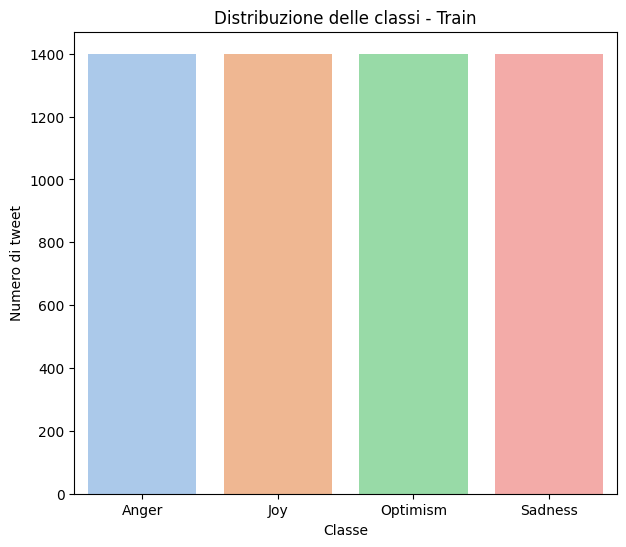

Distribuzione delle classi nel dataset di train:
label
2    0.25
0    0.25
1    0.25
3    0.25
Name: proportion, dtype: float64


In [17]:
# Distribuzione delle classi nel dataset di train
fig, axes = plt.subplots(1, 1, figsize=(7, 6))
sns.countplot(ax=axes, x=df_train['label'], hue=df_train['label'], legend=False, palette="pastel")
axes.set_title("Distribuzione delle classi - Train")
axes.set_xlabel("Classe")
axes.set_ylabel("Numero di tweet")
axes.set_xticks([0, 1, 2, 3])
axes.set_xticklabels(["Anger", "Joy", "Optimism", "Sadness"])

plt.show()

print("Distribuzione delle classi nel dataset di train:")
print(df_train["label"].value_counts(normalize=True))

Come si può notare dopo la **data augmentation**, la distribuzione delle classi nel dataset di train risulta molto più bilanciata rispetto alla situazione iniziale. Questo processo ha permesso di ridurre il rischio di overfitting sulle classi maggioritarie e di fornire al modello una maggiore varietà di esempi, soprattutto per le classi meno rappresentate.

In [18]:
df_train

,text,label
0,“Worry is a down payment on a problem you may never have'. Joyce Meyer. motivation leadership worry,2
1,My roommate: it's okay that we can't spell because we have autocorrect. terrible first world probs,0
2,No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu,1
3,"Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight",0
4,it's pretty depressing when u hit pan on ur favourite highlighter,3
...,...,...
5595,iodine wonder what would happen if iodine were a father. weary,3
5596,So nervous iodine could puke,3
5597,so I picked up my phone!!!' shocking blush face,3
5598,"How can iodine tell Happy Anniversary, when u are not happy.. bitter amp alaya paitpaitanangpeg",3


## Scelta del modello: RoBERTa

### Scelta degli iperparametri

Creiamo un dizionario per settare gli **iperparametriéé del modello. Questi valori sono stati scelti empiricamente, dopo aver testato diverse combinazioni per ottimizzare le prestazioni durante l'addestramento del nostro modello. In particolare:

- `batch_size = 16`: in quanto il valore migliore con riferimento alla quantità di VRAM a disposizione sulle nostre GPU (16 GB);
- `dropout = 0.3`: rappresenta un valore intermedio che non permette al nostro modello di andare in overfitting e di generalizzare abbastanza bene;
- `learning_rate = 1e-5`: questo valore rende il modello abbastanza stabile durante la fase di addestramento. Altri valori testati sono stati `2e-5`, `3e-5` e `1e-6`, con i quali tuttavia abbiamo dei cali improvvisi di performance sulla validation;
- `epochs = 1000`: rappresentano un valore sufficiente per addestrare il modello e far intervenire l'early stopping dopo un numero di epoche sufficiente da non manifestare miglioramenti sulla validation.

In [19]:
hyperparameters = {
    "model_name": "roberta-base",
    "batch_size": 16,
    "learning_rate": 2e-5,
    "epochs": 100,
    "max_length": 74,
    "dropout": 0.3,
    "patience": 7,
    "min_delta": 0.001,
    "num_classes": len(labels),
    "weight_decay": 0.001
}

In [20]:
# Istanziamo un tokenizzatore per il modello scelto
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

### Controllo sulla lunghezza dei tweet

Prima di procedere con la tokenizzazione, è importante verificare le lunghezze dei tweet per due fattori importanti:
- la distribuzione delle lunghezze, per poter ridurre la `max_length` e risparmiare memoria (meno padding nei vettori) e velocizzare l'addestramento (meno dati da processare)
- la presenza di tweet che superano la lunghezza massima consentita dal modello RoBERTa (`max_length = 128` token).

I tweet troppo lunghi verranno troncati dal tokenizer e parte del contenuto potrebbe andare perso.  

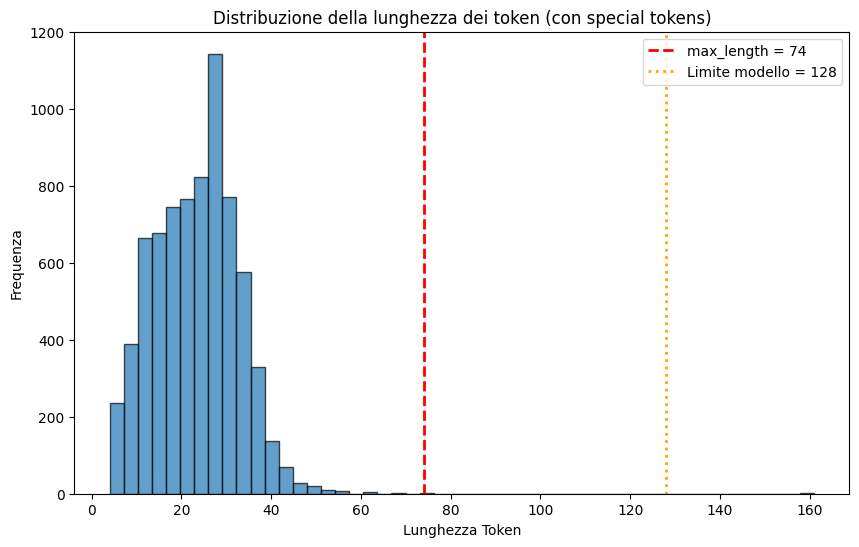

Valore scelto per max_length: 74
Massimo originale nel dataset: 161
Esempi che verrebbero troncati a 74: 3 (0.04%)

Esempi troncati (indice, lunghezza, inizio del testo):
- Indice: 1011, Lunghezza: 161, Testo: Trying to think positive, and not let this situation discourage me sparkle...
- Indice: 4247, Lunghezza: 161, Testo: Trying to think positive, and not let this situation discourage me sparkle...
- Indice: 4861, Lunghezza: 161, Testo: Trying to think positive, and not let this situation discourage me sparkle...


In [21]:
# Calcoliamo la distribuzione delle lunghezze tokenizzate per tutti i set
all_texts = df_train["text"].tolist() + df_val["text"].tolist() + df_test["text"].tolist()
model_max_length = 128  # Limite massimo per RoBERTa-base
chosen_max_length = hyperparameters['max_length']

# Calcoliamo le lunghezze tokenizzate con encode (special tokens inclusi)
token_lengths = [len(tokenizer.encode(t, add_special_tokens=True)) for t in all_texts]

# Troviamo gli indici e le lunghezze dei testi troppo lunghi
too_long = [(idx, length, all_texts[idx]) for idx, length in enumerate(token_lengths) if length > chosen_max_length]

# Quanti esempi superano chosen_max_length
too_long_count = len(too_long)
max_length_in_data = max(token_lengths)

# Visualizzazione distribuzione
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(chosen_max_length, color='r', linestyle='dashed', linewidth=2, label=f"max_length = {chosen_max_length}")
plt.axvline(model_max_length, color='orange', linestyle='dotted', linewidth=2, label=f"Limite modello = {model_max_length}")
plt.title("Distribuzione della lunghezza dei token (con special tokens)")
plt.xlabel("Lunghezza Token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

print(f"Valore scelto per max_length: {chosen_max_length}")
print(f"Massimo originale nel dataset: {max_length_in_data}")
print(f"Esempi che verrebbero troncati a {chosen_max_length}: {too_long_count} ({too_long_count/len(all_texts)*100:.2f}%)\n")

# Mostriamo i primi 5 esempi troppo lunghi
print("Esempi troncati (indice, lunghezza, inizio del testo):")
for idx, length, text in too_long:
    print(f"- Indice: {idx}, Lunghezza: {length}, Testo: {text[:chosen_max_length]}...")


Dall'analisi della distribuzione delle lunghezze dei tweet dopo la tokenizzazione è possibile notare che la quasi totalità dei tweet presenta una lunghezza <= 74 token, con solo due outlier che superano sia questo valore che il limite massimo consentito dal modello RoBERTa (`max_length = 128`).

A questo punto, per diminuire il troncamento dei testi, è poco impattante scegliere il limite del modello o il valore 74, in quanti in entrambi i casi solo due outlier verrebbero troncati dal tokenizer. In ottica di performance, per ridurre il padding e ottimizzare l'addestramento, si preferisce utilizzare il valore `74`.

## Preparazione del dataset

Per poter addestrare il modello, dobbiamo preparare opportunamente il dataset
- **Dataset**: Organizza i dati (testo e label) in una struttura compatibile con PyTorch, permettendo di applicare trasformazioni come la tokenizzazione. Utilizziamo la funzione `map` per tokenizzare il testo di ciascun tweet
- **DataLoader**: Suddivide il dataset in batch, gestisce lo shuffle e prepara i dati per essere processati efficientemente dalla rete neurale durante l’addestramento e la validazione.



In [22]:
def create_dataset(df, tokenizer):
    """Funzione per creare il dataset a partire dal dataframe."""
    dataset = Dataset.from_pandas(df)

    # Tokenizzazione del testo
    dataset = dataset.map(
        lambda x: tokenizer(
            x["text"],
            truncation=True,
            padding="max_length",
            max_length=hyperparameters["max_length"],
        ),
        batched=True,
    )

    return dataset

In [23]:
train_dataset = create_dataset(df_train, tokenizer)
val_dataset = create_dataset(df_val, tokenizer)
test_dataset = create_dataset(df_test, tokenizer)

# Stampiamo il dataset di prova
train_dataset[0]

Map: 100%|██████████| 1421/1421 [00:00<00:00, 27556.47 examples/s]


{'text': "“Worry is a down payment on a problem you may never have'. Joyce Meyer. motivation leadership worry",
 'label': 2,
 'input_ids': [0,
  17,
  48,
  771,
  17649,
  16,
  10,
  159,
  3207,
  15,
  10,
  936,
  47,
  189,
  393,
  33,
  2652,
  12181,
  11392,
  4,
  10563,
  1673,
  4022,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

Questo risultato mostra la tokenizzazione:
- Ogni input_id rappresenta la posizione di quel token nel vocabolario del modello
- Tutti i tweet vengono portati alla stessa lunghezza (max_length), aggiungendo zeri (padding) se sono troppo corti, o tagliando se sono troppo lunghi
- Viene creata una maschera (attention_mask) che indica quali token sono reali (1) e quali sono padding (0).

In [24]:
def create_dataloader(dataset, batch_size, shuffle=False):
    """Funzione per creare un dataloader a partire dal dataset."""
    # Combiniamo i dati
    def collate_fn(examples):
        return {
            'input_ids': torch.tensor([example['input_ids'] for example in examples]),
            'attention_mask': torch.tensor([example['attention_mask'] for example in examples]),
            'labels': torch.tensor([example['label'] for example in examples]),
        }

    # Creiamo il dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle)

    return dataloader

In [25]:
train_dataloader = create_dataloader(train_dataset, hyperparameters['batch_size'], shuffle=True)
val_dataloader = create_dataloader(val_dataset, hyperparameters['batch_size'], shuffle=True)

# Stampiamo un batch di dati
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[    0, 44592,    99,  ...,     1,     1,     1],
        [    0,   118,    74,  ...,     1,     1,     1],
        [    0, 21109, 36473,  ...,     1,     1,     1],
        ...,
        [    0, 11990,  5667,  ...,     1,     1,     1],
        [    0,   894,   969,  ...,     1,     1,     1],
        [    0,   100,   437,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 1, 1, 2, 1, 3, 1, 3, 3, 0, 2, 2, 2, 1, 1, 1])}


## Creazione della rete neurale

Dopo una serie di tentativi, abbiamo costruito la rete neurale con riferimento alla seguente architettura:

- Backbone del modello preaddestrato
- Layer di dropout
- Layer fully connected per restituire il risultato della classificazione (singola uscita)
- Funzione di attivazione sigmoidale

In [26]:
class EarlyStopping:
    """Implementazione dell'early stopping per fermare l'allenamento quando la validation loss non migliora."""
    
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"Nessun miglioramento nella validation loss. Contatore: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping attivato.")

In [27]:
class AlBERToClassifier(nn.Module):
    """Modello di classificazione multiclasse basato su un modello preaddestrato."""
    
    def __init__(self, model_name, dropout):
        super().__init__()
        # Backbone del modello preaddestrato
        self.model = AutoModel.from_pretrained(model_name)
        # Layer di dropout
        self.dropout = nn.Dropout(dropout)
        # Layer fully connected
        self.fc = nn.Linear(self.model.config.hidden_size, 64)
        # Layer di classificazione
        self.classifier = nn.Linear(64, hyperparameters['num_classes'])
        

    def forward(self, input_ids, attention_mask):
        # Otteniamo le rappresentazioni dal modello preaddestrato
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        # Prendiamo il vettore [CLS] (o equivalente) per la classificazione
        cls_output = outputs.last_hidden_state[:, 0, :]

        x = self.fc(cls_output)
        x = self.dropout(x)
        # Passiamo attraverso il layer di classificazione
        x = self.classifier(x)
        return x

### Training e Validation loop

In [28]:
def train_classifier(model, train_dataloader, optimizer, loss_fn, device):
    """Funzione per il training del modello."""

    # Mettiamo il modello in modalità di training
    model.train()

    # Inizializziamo le variabili di loss e predizioni
    epoch_loss = correct_preds = total_preds = 0

    # Creiamo due liste per le predizioni e le labels
    all_preds = []
    all_labels = []

    # Iteriamo il dataloader
    for batch in tqdm(train_dataloader, total=len(train_dataloader), desc="Training"):
        # Estraiamo i dati dal batch
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Azzeriamo i gradienti
        optimizer.zero_grad()
        # Passiamo il batch al modello
        outputs = model(input_ids, attention_mask)
        # La loss è calcolata internamente a CrossEntropyLoss 
        loss = loss_fn(outputs, labels.long())
        # Calcoliamo i gradienti
        loss.backward()
        # Ottimizziamo
        optimizer.step()
        # Aggiungiamo la loss
        epoch_loss += loss.item()
        # Ricaviamo le predizioni prendendo la classe con probabilità più alta
        preds = torch.argmax(outputs, dim=-1)

        # Aggiungiamo le predizioni corrette e labels totali
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calcoliamo il numero di predizioni corrette
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    # Calcoliamo la loss media
    epoch_loss /= len(train_dataloader)
    # Calcoliamo l'accuracy
    accuracy = correct_preds / total_preds
    # Calcoliamo l'F1 score == 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, accuracy, f1

In [29]:
# Funzione di validazione
def validate_classifier(model, val_dataloader, loss_fn, device, collect_preds=None):
    """Funzione per la validazione del modello."""

    # Mettiamo il modello in modalità di eval
    model.eval()
    # Inizializziamo le variabili di loss e predizioni
    epoch_loss = correct_preds = total_preds = 0
    # Creiamo due liste per le predizioni e le labels
    all_preds = []
    all_labels = []

    # Iteriamo il dataloader
    with torch.no_grad():
        for batch in tqdm(val_dataloader, total=len(val_dataloader), desc="Validation"):
            # Estraiamo i dati dal batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Passiamo il batch al modello
            outputs = model(input_ids, attention_mask)
            # La loss è calcolata internamente a CrossEntropyLoss
            loss = loss_fn(outputs, labels.long())
            # Aggiungiamo la loss
            epoch_loss += loss.item()
            # Predizioni prendendo la classe con probabilità più alta
            preds = torch.argmax(outputs, dim=-1)

            # Aggiungiamo le predizioni corrette e labels totali
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calcoliamo il numero di predizioni corrette
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    # Calcoliamo la loss media
    epoch_loss /= len(val_dataloader)
    # Calcoliamo l'accuracy
    accuracy = correct_preds / total_preds
    # Calcoliamo l'F1 sulla base di tutte le predizioni
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Ritorniamo la loss e l'accuracy. Se richiesto, ritorniamo anche le predizioni.
    if collect_preds:
        return epoch_loss, accuracy, f1, all_labels, all_preds
    else:
        return epoch_loss, accuracy, f1

In [30]:
def generate_final_plots(history, all_labels, all_preds):
    """Genera i plot finali delle metriche di training e la matrice di confusione."""

    # Grafico delle perdite
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_loss"], label="Train Loss", marker="o")
    plt.plot(history["val_loss"], label="Validation Loss", marker="o")
    plt.title("Loss per epoca")
    plt.xlabel("Epoca")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.tight_layout()

    # Grafico delle accuratezze
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_accuracy"], label="Train Accuracy", marker="o")
    plt.plot(history["val_accuracy"], label="Validation Accuracy", marker="o")
    plt.title("Accuracy per epoca")
    plt.xlabel("Epoca")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.tight_layout()

    # Grafico dell'F1-score
    plt.figure(figsize=(12, 6))
    plt.plot(history["train_f1"], label="Train F1-Score", marker="o")
    plt.plot(history["val_f1"], label="Validation F1-Score", marker="o")
    plt.title("F1-Score per epoca")
    plt.xlabel("Epoca")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.tight_layout()

    # Matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [31]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, early_stopping=None):
    """Funzione per addestrare e valutare il modello."""

    # Dizionario per tenere traccia delle metriche di training e validazione
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_f1": [],
        "val_f1": [],
    }

    # Variabile per tenere traccia del miglior F1 score trovato finora
    best_f1 = 0.0

    # Liste contenenti le predizioni e le labels
    all_labels = []
    all_preds = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training per la singola epoca
        train_loss, train_accuracy, train_f1 = train_classifier(model, train_dataloader, optimizer, loss_fn, device)
        # Validazione per la singola epoca
        validation_loss, validation_accuracy, f1, labels, preds = validate_classifier(model, val_dataloader, loss_fn, device, collect_preds=True)
        # Salviamo le predizioni e le labels
        all_labels.extend(labels)
        all_preds.extend(preds)

        # Salviamo i dati di training e validazione
        history["train_loss"].append(train_loss)
        history["val_loss"].append(validation_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(validation_accuracy)
        history["train_f1"].append(train_f1)
        history["val_f1"].append(f1)

        # Stampiamo i risultati sulle metriche
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
        print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Validation F1: {f1:.4f}")

        # Salviamo il miglior modello basato sull'F1 score
        if f1 > best_f1:
            best_f1 = f1
            print(f"New best F1 score: {best_f1:.4f}")
            torch.save(model.state_dict(), "best_model_emotion.pth")

        # Early stopping
        if early_stopping:
            early_stopping(validation_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Generiamo i grafici alla fine dell'addestramento
    generate_final_plots(history, all_labels, all_preds)

    # Restituiamo il miglior F1 score trovato durante l'addestramento
    print(f"Best F1 score: {best_f1:.4f}")

In [32]:
model_name = hyperparameters['model_name']
dropout = hyperparameters['dropout']
learning_rate = hyperparameters['learning_rate']
num_epochs = hyperparameters['epochs']
patience = hyperparameters['patience']
min_delta = hyperparameters['min_delta']
weight_decay = hyperparameters['weight_decay']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Istanziamo il modello
model = AlBERToClassifier(model_name=model_name, dropout=dropout).to(device)

# Definiamo la loss
loss = nn.CrossEntropyLoss()

# Definiamo l'ottimizzatore
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Definiamo l'early stopping
early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Stampiamo il sommario del modello
summary(model)

Layer (type:depth-idx)                                            Param #
AlBERToClassifier                                                 --
├─RobertaModel: 1-1                                               --
│    └─RobertaEmbeddings: 2-1                                     --
│    │    └─Embedding: 3-1                                        38,603,520
│    │    └─Embedding: 3-2                                        394,752
│    │    └─Embedding: 3-3                                        768
│    │    └─LayerNorm: 3-4                                        1,536
│    │    └─Dropout: 3-5                                          --
│    └─RobertaEncoder: 2-2                                        --
│    │    └─ModuleList: 3-6                                       85,054,464
│    └─RobertaPooler: 2-3                                         --
│    │    └─Linear: 3-7                                           590,592
│    │    └─Tanh: 3-8                                             --


Epoch 1/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 27.71it/s]


Train Loss: 0.7427, Train Accuracy: 0.7036, Train F1: 0.7032
Validation Loss: 0.6449, Validation Accuracy: 0.7941, Validation F1: 0.7422
New best F1 score: 0.7422

Epoch 2/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 29.51it/s]


Train Loss: 0.2975, Train Accuracy: 0.9014, Train F1: 0.9012
Validation Loss: 0.5619, Validation Accuracy: 0.8075, Validation F1: 0.7474
New best F1 score: 0.7474

Epoch 3/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 29.72it/s]


Train Loss: 0.1772, Train Accuracy: 0.9457, Train F1: 0.9457
Validation Loss: 0.6549, Validation Accuracy: 0.8182, Validation F1: 0.7614
New best F1 score: 0.7614
Nessun miglioramento nella validation loss. Contatore: 1/7

Epoch 4/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 28.72it/s]


Train Loss: 0.1177, Train Accuracy: 0.9623, Train F1: 0.9623
Validation Loss: 0.7969, Validation Accuracy: 0.8048, Validation F1: 0.7474
Nessun miglioramento nella validation loss. Contatore: 2/7

Epoch 5/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 29.68it/s]


Train Loss: 0.0782, Train Accuracy: 0.9764, Train F1: 0.9764
Validation Loss: 0.8258, Validation Accuracy: 0.7995, Validation F1: 0.7417
Nessun miglioramento nella validation loss. Contatore: 3/7

Epoch 6/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 30.11it/s]


Train Loss: 0.0580, Train Accuracy: 0.9816, Train F1: 0.9816
Validation Loss: 0.8952, Validation Accuracy: 0.8048, Validation F1: 0.7296
Nessun miglioramento nella validation loss. Contatore: 4/7

Epoch 7/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 29.78it/s]


Train Loss: 0.0632, Train Accuracy: 0.9802, Train F1: 0.9802
Validation Loss: 0.9320, Validation Accuracy: 0.8102, Validation F1: 0.7367
Nessun miglioramento nella validation loss. Contatore: 5/7

Epoch 8/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 30.29it/s]


Train Loss: 0.0739, Train Accuracy: 0.9788, Train F1: 0.9787
Validation Loss: 0.8760, Validation Accuracy: 0.8155, Validation F1: 0.7578
Nessun miglioramento nella validation loss. Contatore: 6/7

Epoch 9/100


Validation: 100%|██████████| 24/24 [00:00<00:00, 28.92it/s]

Train Loss: 0.0441, Train Accuracy: 0.9868, Train F1: 0.9868
Validation Loss: 0.8982, Validation Accuracy: 0.7995, Validation F1: 0.7237
Nessun miglioramento nella validation loss. Contatore: 7/7
Early stopping attivato.
Early stopping at epoch 9


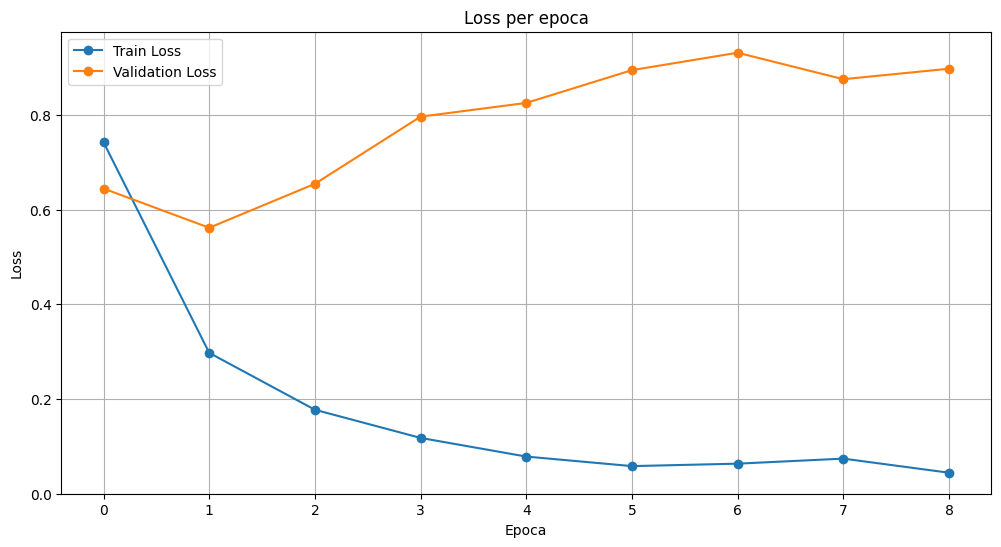

<Figure size 640x480 with 0 Axes>

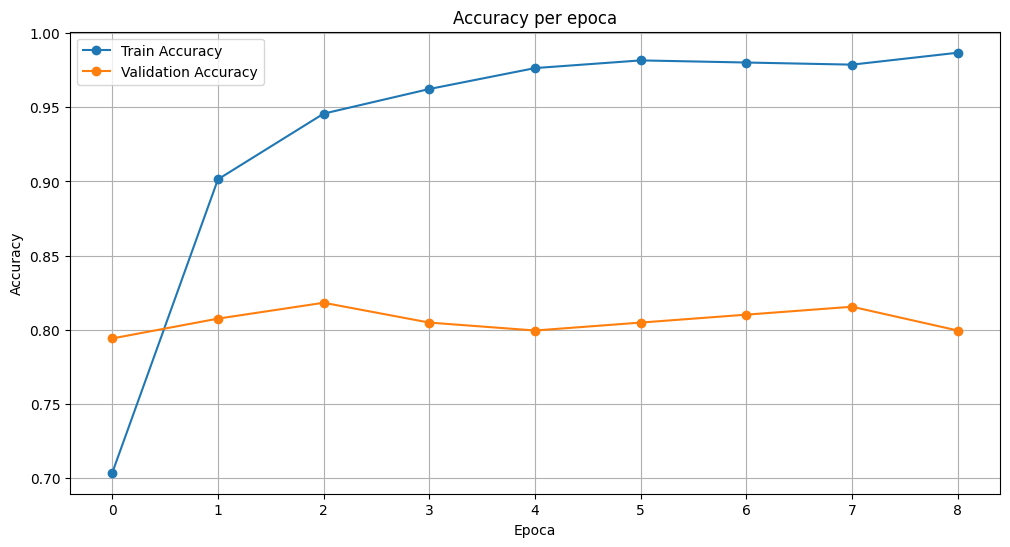

<Figure size 640x480 with 0 Axes>

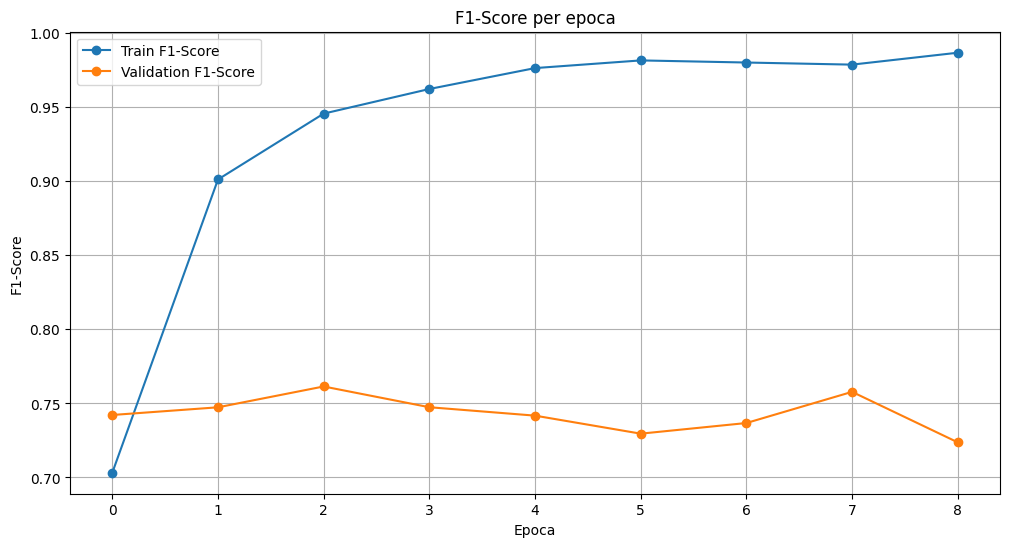

<Figure size 640x480 with 0 Axes>

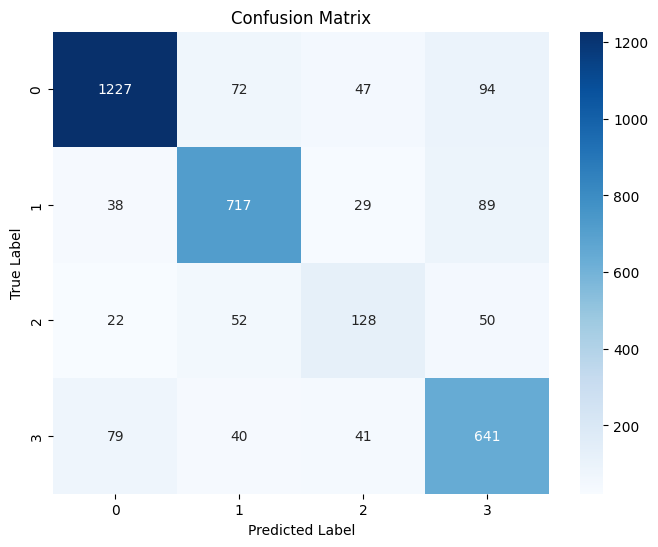

Best F1 score: 0.7614


In [34]:
# Avviamo l'addestramento e la valutazione
train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss, num_epochs, device, early_stopping)

## Testing del modello

Creiamo una funzione di dataloader differente poiché per quanto concerne il dataset di test non abbiamo a disposizione le labels. Inoltre, dovendo stampare le predizioni mettiamo il `batch_size` a 1 in quanto dobbiamo testare il modello su ogni singolo tweet.

In [35]:
def create_test_dataloader(dataset):
    """Funzione per creare un dataloader a partire dal dataset di test."""

    def collate_fn(examples):
        """Collate function per il dataloader di test."""
        return {
            'input_ids': torch.tensor([example['input_ids'] for example in examples]),
            'attention_mask': torch.tensor([example['attention_mask'] for example in examples]),
        }

    # Creiamo il dataloader
    dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
    return dataloader

# Creiamo il dataloader per il test set
test_dataloader = create_test_dataloader(test_dataset)

In [36]:
def test_classifier(model, test_dataloader, device):
    """Funzione per il testing del modello."""

    # Mettiamo il modello in modalità di eval
    model.eval()

    # Creiamo una lista con le predizioni
    all_preds = []

    # Iteriamo il dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader), desc="Testing"):
            # Estraiamo i dati dal batch
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            # Passiamo il batch al modello
            outputs = model(input_ids, attention_mask)
            # Predizioni prendendo la classe con probabilità più alta
            preds = torch.argmax(outputs, dim=-1)
            # Aggiungiamo le predizioni corrette e labels totali
            all_preds.extend(preds.cpu().numpy())

    return all_preds

In [37]:
# Carica il miglior modello
model = AlBERToClassifier(model_name=model_name, dropout=dropout).to(device)
model.load_state_dict(torch.load("best_model_emotion.pth"))

# Genera predizioni sul test set
test_preds = test_classifier(model, test_dataloader, device)
print(f"Predizioni sul test set: {test_preds[:10]}...")

# Salva in formato CSV
pd.DataFrame(test_preds, columns=["prediction"]).to_csv("emotion_predictions.csv", index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 1421/1421 [00:15<00:00, 93.12it/s]

Predizioni sul test set: [np.int64(3), np.int64(0), np.int64(3), np.int64(1), np.int64(1), np.int64(0), np.int64(3), np.int64(3), np.int64(1), np.int64(0)]...
